In [249]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
%matplotlib notebook

In [250]:
# load camera parameters
camera_parameters = np.genfromtxt("objectSR_par.txt")
cam_num = camera_parameters.shape[0]
camera_parameters = camera_parameters[~np.isnan(camera_parameters)]
camera_parameters = np.reshape(camera_parameters,(cam_num,21))

K = np.array((camera_parameters[0,0:9]))
R = np.array((camera_parameters[0,9:18]))
t = np.array((camera_parameters[0,18:21]))
for i in range(cam_num-1):
    K = np.hstack((K,np.array(camera_parameters[i+1,0:9])))
    R = np.hstack((R,np.array(camera_parameters[i+1,9:18])))
    t = np.hstack((t,np.array(camera_parameters[i+1,18:21])))
K = np.reshape(K,(cam_num,9))
R = np.reshape(R,(cam_num,9))
t = np.reshape(t,(cam_num,3))
np.transpose(K[0].reshape(3,3))
#np.hstack((np.transpose(R[0].reshape(3,3)),np.transpose(t[0].reshape(1,3))))

array([[1.122369e+03, 0.000000e+00, 1.095653e+02],
       [0.000000e+00, 1.110314e+03, 1.089183e+02],
       [0.000000e+00, 0.000000e+00, 1.000000e+00]])

In [251]:
projectionmatrix = []
for i in range(cam_num):
    projectionmatrix.append((np.transpose(K[i].reshape(3,3))) @ (np.hstack
                                                                 ((np.transpose(R[i].reshape(3,3)),np.transpose(t[i].reshape(1,3))))))
    

In [252]:
def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]

In [258]:
import cv2
import numpy as np
 

# if __name__ == '__main__' :
#     # Read image
#     im1 = cv2.imread("sill3.png")
#     # Select ROI
#     r1 = cv2.selectROI(im1)
#     im2 = cv2.imread('sill2.png')
#     r2 = cv2.selectROI(im2)
#     # Crop image
#     imCrop = im1[int(r1[1]):int(r1[1]+r1[3]), int(r1[0]):int(r1[0]+r1[2])]
#     # Display cropped image
#     cv2.imshow("Image", imCrop)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [6]:
uvs1 = [[r1[0], r1[1]], [r1[0], r1[1]], [r1[0]+r1[2], r1[1]],
        [r1[0]+r1[2], r1[1]], [r1[0], r1[1]+r1[3]]]
 
uvs2 =  [[r2[0], r2[1]], [r2[0]+r2[2], r2[1]], [r2[0], r2[1]],
         [r2[0]+r2[2], r2[1]], [r2[0], r2[1]+r2[3]]]
 
uvs1 = np.array(uvs1)
uvs2 = np.array(uvs2)

p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(projectionmatrix[0], projectionmatrix[1], uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)
#store min max and difference of x y and z vol
xyz = [] 
for i in range (3):
    rang = int(max(p3ds[:,i]) - min(p3ds[:,i]))
    if rang > 80:
        rang = int(rang/2)
    xyz.append([min(p3ds[:,i]), max(p3ds[:,i]), rang])
#xyz[2][0] = xyz[2][0]-40
#xyz[2][1] = xyz[2][1]+40
#xyz[2][2] = xyz[2][2] + 40

Triangulated point: 
[231.97338819 123.92101039  -6.2540226 ]
Triangulated point: 
[223.06036419  23.6084245   39.72739187]
Triangulated point: 
[234.16605563  34.89661686 -63.2896496 ]
Triangulated point: 
[224.25522984 -63.83067024  -9.88419604]
Triangulated point: 
[ 77.38213358 125.44407909 -20.74001125]


In [7]:
xyz

[[77.3821335756987, 234.16605563458847, 78],
 [-63.83067023709653, 125.44407908557676, 94],
 [-63.289649600377174, 39.72739187173793, 51]]

In [8]:
#img = Image.open('frame00000.pgm')
#img = np.array(img)
x = np.linspace(xyz[0][0],xyz[0][1],xyz[0][2])
y = np.linspace(xyz[1][0],xyz[1][1],xyz[1][2])
z = np.linspace(xyz[2][0],xyz[2][1],xyz[2][2])
Grid = np.ones((xyz[0][2],xyz[1][2],xyz[2][2]))
Grid = np.bool_((Grid))
img = []
for n in range(5):
    file = 'cam'+str(n)+'/silhouette/frame00000.pgm'
    temp = Image.open(file)
    temp = np.array(temp)
    img.append(temp)

    for i in range(xyz[0][2]):
        for j in range(xyz[1][2]):
            for k in range(xyz[2][2]):
                worldpoint = np.array(([[x[i]],[y[j]],[z[k]],[1]]))
                imagepoint1 = projectionmatrix[n] @ worldpoint
                imagepoint1 = imagepoint1/imagepoint1[2]
                if imagepoint1[0] > 319 or imagepoint1[1] > 299:
                    Grid[i][j][k] = False
                else:
                    if Grid[i][j][k] == True and img[n][int(imagepoint1[1])][int(imagepoint1[0])] != 255:
                        Grid[i][j][k] = False


In [9]:
Grid = (Grid >0)
print('Number of basis function')
Grid.sum()

Number of basis function


5346

In [328]:
print(xyz)

[[79.89212076770677, 240.35221010863629, 80], [-38.27140310828549, 131.2299338258716, 84], [-52.64144508681254, 39.44516848071913, 46]]


In [329]:
u = 150
v = 100
Z = xyz[2][1]
print(Z)
a11 = R[0][2] * (u - K[0][6]) - R[0][0] * K[0][0]
a12 = R[0][5] * (u - K[0][6]) - R[0][3] * K[0][0]
a21 = R[0][2] * (v - K[0][7]) - R[0][1] * K[0][4]
a22 = R[0][5] * (v - K[0][7]) - R[0][4] * K[0][4]
b11 = t[0][0] * K[0][0] - t[0][2] * (u - K[0][6]) - Z * (R[0][8] * (u - K[0][6]) - R[0][6] * K[0][0])
b21 = t[0][1] * K[0][4] - t[0][2] * (v - K[0][7]) - Z * (R[0][8] * (v - K[0][7]) - R[0][7] * K[0][4])
A = np.array(([[a11, a12], [a21, a22]]))
b = np.array(([[b11],[b21]]))
X =  np.linalg.solve(A, b)
#if (X[0][0] > xyz[0][0] or X[0][0] < xyz[0][1]) and  (X[1][0] > xyz[1][0] or X[1][0] < xyz[1][1])
print(X)

39.44516848071913
[[180.84267094]
 [-17.32831307]]


In [331]:
xyz

[[79.89212076770677, 240.35221010863629, 80],
 [-38.27140310828549, 131.2299338258716, 84],
 [-52.64144508681254, 39.44516848071913, 46]]

In [10]:


def xyplane(Z,R,K,t,u,v,n,xyz):
    xcoff1 = R[n][2] * (u - K[n][6]) - R[n][0] * K[n][0]
    ycoff1 = R[n][5] * (u - K[n][6]) - R[n][3] * K[n][0]
    zcoff1 = R[n][8] * (u - K[n][6]) - R[n][6] * K[n][0]
    xcoff2 = R[n][2] * (v - K[n][7]) - R[n][1] * K[n][4]
    ycoff2 = R[n][5] * (v - K[n][7]) - R[n][4] * K[n][4]
    zcoff2 = R[n][8] * (v - K[n][7]) - R[n][7] * K[n][4]

    d11 = t[n][0] * K[n][0] - t[n][2] * (u - K[n][6])
    d21 = t[n][1] * K[n][4] - t[n][2] * (v - K[n][7]) 

    b11 = d11 - Z * zcoff1
    b21 = d21 - Z * zcoff2
    a11 = xcoff1
    a12 = ycoff1
    a21 = xcoff2
    a22 = ycoff2
    #print(xcoff1,ycoff1,zcoff1,xcoff2,ycoff2,zcoff2)
    
    
    A = np.array(([[a11, a12], [a21, a22]]))
    b = np.array(([[b11],[b21]]))
    X =  np.linalg.solve(A, b)
    #print(A)
    #print(X)
    worldpoint = np.array(([[X[0][0]],[X[1][0]],[Z]]))
    Flag = False
    if (X[0][0] > xyz[0][0] and X[0][0] < xyz[0][1]) and  (X[1][0] > xyz[1][0] and X[1][0] < xyz[1][1]):
        pass
    else:
        Flag = True
    return Flag, worldpoint

In [11]:
A = np.array(([[-12],[10],[15]]))
B = np.array(([11],[12],[13]))
C = A-B
stepx = C[0][0] / abs(C[0][0]) * ((xyz[0][1] - xyz[0][0]) / (xyz[0][2]))
stepy = (C[1][0] / abs(C[1][0])) * 2
stepz = C[2][0] / abs(C[2][0])
print(int(stepx),stepy,stepz)

-2 -2.0 1.0


In [12]:

def yzplane(X,R,K,t,u,v,n,xyz):
    xcoff1 = R[n][2] * (u - K[n][6]) - R[n][0] * K[n][0]
    ycoff1 = R[n][5] * (u - K[n][6]) - R[n][3] * K[n][0]
    zcoff1 = R[n][8] * (u - K[n][6]) - R[n][6] * K[n][0]
    xcoff2 = R[n][2] * (v - K[n][7]) - R[n][1] * K[n][4]
    ycoff2 = R[n][5] * (v - K[n][7]) - R[n][4] * K[n][4]
    zcoff2 = R[n][8] * (v - K[n][7]) - R[n][7] * K[n][4]

    d11 = t[n][0] * K[n][0] - t[n][2] * (u - K[n][6])
    d21 = t[n][1] * K[n][4] - t[n][2] * (v - K[n][7]) 

    b11 = d11 - X * xcoff1
    b21 = d21 - X * xcoff2
    a11 = zcoff1
    a12 = ycoff1
    a21 = zcoff2
    a22 = ycoff2
    A = np.array(([[a11, a12], [a21, a22]]))
    b = np.array(([[b11],[b21]]))
    Z =  np.linalg.solve(A, b)
    #print(A)
    #print(Z)
    worldpoint = np.array(([[X],[Z[1][0]],[Z[0][0]]]))
    Flag = False
    if (Z[0][0] > xyz[2][0] and Z[0][0] < xyz[2][1]) and  (Z[1][0] > xyz[1][0] and Z[1][0] < xyz[1][1]):
        pass
    else:
        Flag = True
    return Flag, worldpoint

In [13]:

def xzplane(Y,R,K,t,u,v,n,xyz):
    xcoff1 = R[n][2] * (u - K[n][6]) - R[n][0] * K[n][0]
    ycoff1 = R[n][5] * (u - K[n][6]) - R[n][3] * K[n][0]
    zcoff1 = R[n][8] * (u - K[n][6]) - R[n][6] * K[n][0]
    xcoff2 = R[n][2] * (v - K[n][7]) - R[n][1] * K[n][4]
    ycoff2 = R[n][5] * (v - K[n][7]) - R[n][4] * K[n][4]
    zcoff2 = R[n][8] * (v - K[n][7]) - R[n][7] * K[n][4]

    d11 = t[n][0] * K[n][0] - t[n][2] * (u - K[n][6])
    d21 = t[n][1] * K[n][4] - t[n][2] * (v - K[n][7]) 

    b11 = d11 - Y * ycoff1
    b21 = d21 - Y * ycoff2
    a11 = xcoff1
    a12 = zcoff1
    a21 = xcoff2
    a22 = zcoff2
    A = np.array(([[a11, a12], [a21, a22]]))
    b = np.array(([[b11],[b21]]))
    Z =  np.linalg.solve(A, b)
    #print(Z)
    worldpoint = np.array(([[Z[0][0]],[Y],[Z[1][0]]]))
    #print(Z[1][0],xyz[2][0],Z[1][0],xyz[2][1])
    #print(worldpoint)
    Flag = False
    if (Z[0][0] > xyz[0][0] and Z[0][0] < xyz[0][1]) and  (Z[1][0] > xyz[2][0] and Z[1][0] < xyz[2][1]):
        pass
    else:
        Flag = True
    return Flag, worldpoint

In [87]:
def get_voxel(worldpoint, xyz):
    voxel_x = ((worldpoint[0][0] - xyz[0][0]) / (xyz[0][1]-xyz[0][0])) * xyz[0][2]
    voxel_y = ((worldpoint[1][0] - xyz[1][0]) / (xyz[1][1]-xyz[1][0])) * xyz[1][2]
    voxel_z = ((worldpoint[2][0] - xyz[2][0]) / (xyz[2][1]-xyz[2][0])) * xyz[2][2]
    return int(voxel_x), int(voxel_y), int(voxel_z)

In [253]:
def Smatrix(xyz,Grid,row,col,data,d,x,y,z,u,v,count):
    if x < xyz[0][2] and y < xyz[1][2] and z < xyz[2][2]:
        if Grid[x][y][z]:
            row.append(count)
            col.append(xyz[0][2]*xyz[1][2]*z+xyz[1][2]*x+y)
            data.append(d)
    return row,col,data
    

In [254]:
def raytracing(R,K,t,u,v,n,xyz,worldpoint1,worldpoint2,voxel,Grid,row,col,data,count,r,g,b,rpixels,gpixels,bpixels):
    #find step size 
    C = worldpoint2-worldpoint1
    stepx = int(C[0][0] / abs(C[0][0]) * ((xyz[0][1] - xyz[0][0]) / (xyz[0][2])))
    stepy = int(C[1][0] / abs(C[1][0]) * ((xyz[1][1] - xyz[1][0]) / (xyz[1][2])))
    stepz = int(C[2][0] / abs(C[2][0]) * ((xyz[2][1] - xyz[2][0]) / (xyz[2][2])))
    #count first voxel
    #print(worldpoint1)
    x, y, z = get_voxel(worldpoint1, xyz)
    #print(stepx,stepy,stepz)
    if voxel[x][y][z] == n:
        voxel[x][y][z] = voxel[x][y][z] + 1
    #Grid[x][y][z] = n+1
    
    #start raytracing algorithm
    while (worldpoint1[0][0] <= xyz[0][1]) and (worldpoint1[1][0] <= xyz[1][1]) and (
        worldpoint1[2][0] <= xyz[2][1]) and (worldpoint1[0][0] >= xyz[0][0]) and (
        worldpoint1[1][0] >= xyz[1][0]) and (worldpoint1[2][0] >= xyz[2][0]) :
    
        X = ((((x + stepx) - 0)/xyz[0][2]) * (xyz[0][1] - xyz[0][0])) + xyz[0][0]
        #X = worldpoint1[0][0]+stepx
        flag, worldpoint_x = yzplane(X,R,K,t,u,v,n,xyz)
        #Y = worldpoint1[1][0]+stepy
        Y = ((((y + stepy) - 0)/xyz[1][2]) * (xyz[1][1] - xyz[1][0])) + xyz[1][0]
        flag, worldpoint_y = xzplane(Y,R,K,t,u,v,n,xyz)
        #Z = worldpoint1[2][0]+stepz
        Z = ((((z + stepz) - 0)/xyz[2][2]) * (xyz[2][1] - xyz[2][0])) + xyz[2][0]
        flag, worldpoint_z = xyplane(Z,R,K,t,u,v,n,xyz)
        if np.linalg.norm(worldpoint_x - worldpoint1) < np.linalg.norm(worldpoint_y - worldpoint1):
            if np.linalg.norm(worldpoint_z - worldpoint1) < np.linalg.norm(worldpoint_x - worldpoint1):
                d = np.linalg.norm(worldpoint_z - worldpoint1)
                worldpoint1 = worldpoint_z
                x, y, z = get_voxel(worldpoint1, xyz)
                row,col,data = Smatrix(xyz,Grid,row,col,data,d,x,y,z,u,v,count)
                
            else:
                d = np.linalg.norm(worldpoint_x - worldpoint1)
                worldpoint1 = worldpoint_x
                x, y, z = get_voxel(worldpoint1, xyz)
                row,col,data = Smatrix(xyz,Grid,row,col,data,d,x,y,z,u,v,count)
        else:
            if np.linalg.norm(worldpoint_z - worldpoint1) < np.linalg.norm(worldpoint_y - worldpoint1):
                d = np.linalg.norm(worldpoint_z - worldpoint1)
                worldpoint1 = worldpoint_z
                x, y, z = get_voxel(worldpoint1, xyz)
                row,col,data = Smatrix(xyz,Grid,row,col,data,d,x,y,z,u,v,count)
            else:
                d = np.linalg.norm(worldpoint_y - worldpoint1)
                worldpoint1 = worldpoint_y
                x, y, z = get_voxel(worldpoint1, xyz)
                row,col,data = Smatrix(xyz,Grid,row,col,data,d,x,y,z,u,v,count)
        
        if voxel[x][y][z] == n:
            voxel[x][y][z] = voxel[x][y][z] + 1
        #Grid[x][y][z] = n+1
    temp = count
    count = row[-1] + 1 if len(row) else count
    if temp == count-1:
        rpixels = np.append(rpixels,r[v][u]) if rpixels.size else r[v][u]
        gpixels = np.append(gpixels,g[v][u]) if gpixels.size else g[v][u]
        bpixels = np.append(bpixels,b[v][u]) if bpixels.size else b[v][u]
    
    return Grid,row,col,data,count,r,g,b,rpixels,gpixels,bpixels
    
    

In [255]:
#x = np.linspace(xyz[0][0],xyz[0][1],xyz[0][2])
#y = np.linspace(xyz[1][0],xyz[1][1],xyz[1][2])
#z = np.linspace(xyz[2][0],xyz[2][1],xyz[2][2])
voxel = np.zeros((xyz[0][2]+4,xyz[1][2]+4,xyz[2][2]+4))
img = []
rpixels = np.array(())
gpixels = np.array(())
bpixels = np.array(())
plotpoints = []
row = []
col = []
data = []
count = 0
for n in range(5):
    file = 'cam'+str(n)+'/silhouette/frame00000.pgm'
    temp = Image.open(file)
    temp = np.array(temp)
    img.append(temp)
    rowimg = temp.shape[0]
    colimg = temp.shape[1]
    file = 'cam'+str(n)+'/data/frame00000.png'
    temp = Image.open(file)
    temp = np.array(temp)
    r,g,b = np.dsplit(temp,3)
    
    

    if n < 5 :
        for u in range(img[n].shape[1]):
            for v in range(img[n].shape[0]):
                if img[n][v][u] == 255:
                    Z = xyz[2][0]
                    Flag, worldpoint2 = xyplane(Z+10,R,K,t,u,v,n,xyz)
                    Flag, worldpoint1 = xyplane(Z,R,K,t,u,v,n,xyz)
                    #Flag = True
                    if Flag:
                        #print(worldpoint1)
                        X = xyz[0][0]
                        Flag, worldpoint2 = yzplane(X+10,R,K,t,u,v,n,xyz)
                        Flag, worldpoint1 = yzplane(X,R,K,t,u,v,n,xyz)
                        if Flag:
                            Y = xyz[1][0]
                            Flag, worldpoint2 = xzplane(Y+10,R,K,t,u,v,n,xyz)
                            Flag, worldpoint1 = xzplane(Y,R,K,t,u,v,n,xyz)
                            if Flag:
                                Z = xyz[2][1]
                                Flag, worldpoint2 = xyplane(Z-10,R,K,t,u,v,n,xyz)
                                Flag, worldpoint1 = xyplane(Z,R,K,t,u,v,n,xyz)
                                #print(worldpoint1)

                                if Flag:
                                    X = xyz[0][1]
                                    Flag, worldpoint2 = yzplane(X-10,R,K,t,u,v,n,xyz)
                                    Flag, worldpoint1 = yzplane(X,R,K,t,u,v,n,xyz)
                                    #print(worldpoint1,Flag)
                                    
                                    if Flag:
                                        Y = xyz[1][1]
                                        Flag, worldpoint2 = xzplane(Y-10,R,K,t,u,v,n,xyz)
                                        Flag, worldpoint1 = xzplane(Y,R,K,t,u,v,n,xyz)
                                        #print(worldpoint1)
                                        
                                        

                    if not Flag:
                        Grid,row,col,data,count,r,g,b,rpixels,gpixels,bpixels = raytracing(
                            R,K,t,u,v,n,xyz,worldpoint1,worldpoint2,voxel,Grid,row,col,
                            data,count,r,g,b,rpixels,gpixels,bpixels)
        

In [206]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [257]:
S = coo_matrix((data, (row, col)), shape=(rpixels.shape[0],xyz[0][2]*xyz[1][2]*xyz[2][2]))
#S = coo_matrix((data, (row, col)), shape=(320*300*5,xyz[0][2]*xyz[1][2]*xyz[2][2]))
#for i in range(15000):
S.getrow(1)

<1x373932 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [247]:

i = [row,col]
v = data
S= torch.sparse_coo_tensor(i, v, (rpixels.shape[0],xyz[0][2]*xyz[1][2]*xyz[2][2]),dtype=torch.float64)
rpixels = torch.tensor(rpixels,dtype=torch.float64)
gpixels = torch.tensor(gpixels,dtype=torch.float64)
bpixels = torch.tensor(bpixels,dtype=torch.float64)


/tmp/ipykernel_4793/3203824742.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rpixels = torch.tensor(rpixels,dtype=torch.float64)
/tmp/ipykernel_4793/3203824742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpixels = torch.tensor(gpixels,dtype=torch.float64)
/tmp/ipykernel_4793/3203824742.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bpixels = torch.tensor(bpixels,dtype=torch.float64)


In [248]:
S[0]

tensor(indices=tensor([[367758, 360428, 353098, 345768, 338438, 331108, 323778,
                        316448, 309118, 301787, 294457, 294458, 287128, 279798,
                        272468, 265138, 257808, 250477, 250479, 243149, 235819,
                        228489, 221159, 213829, 206499, 199169, 191839, 184509,
                        177178, 177180, 169850, 162520, 155190, 147860]]),
       values=tensor([4.4547, 4.4657, 4.4657, 4.4657, 4.4657, 4.4657, 4.4657,
                      4.4657, 4.4657, 4.4657, 2.2328, 4.4657, 2.2328, 4.4657,
                      4.4657, 4.4657, 4.4657, 4.4657, 2.2328, 4.4657, 4.4657,
                      4.4657, 4.4657, 4.4657, 4.4657, 4.4657, 4.4657, 4.4657,
                      4.4657, 2.2328, 4.4657, 4.4657, 4.4657, 4.4657]),
       size=(373932,), nnz=34, dtype=torch.float64, layout=torch.sparse_coo)

In [243]:
class train(torch.utils.data.Dataset):
    def __init__(self, is_train, S,pixels):
        self.features, self.labels = (S,pixels)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

    def __len__(self):
        return len(self.features)

In [244]:
train_iter1 = torch.utils.data.DataLoader(train(is_train=True,S = S, pixels = rpixels)
                                          ,batch_size=64, shuffle=True)

read 11425 training examples


In [212]:
n_epochs = 15
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [213]:
class lefthandside():
    
    def __init__(self):
        super().__init__()
    
    def forward(self, Si, batch_idx):
        #x = (Si  @ network.avector)
        x = (torch.sparse.mm(Si,network.avector))
        #x = Si @ network.avector
        return x

In [214]:
class Net(nn.Module):
    def __init__(self, a, b):
        super(Net, self).__init__()
        self.a = a
        self.b = b
        self.lefthand = lefthandside()
        self.register_parameter(name='avector', param=torch.nn.Parameter(self.a))
        self.register_parameter(name='bvector', param=torch.nn.Parameter(self.b))
        

    def forward(self, Si, batch_idx):
        x = self.lefthand.forward(Si, batch_idx)

        
        return x

In [215]:
a = torch.tensor(torch.zeros(xyz[0][2]*xyz[1][2]*xyz[2][2],1),dtype=torch.float64,requires_grad=True)
b = torch.tensor(torch.rand(1),dtype=torch.float64,requires_grad=True)
#b  = torch.tensor(np.zeros((28 * len(position), 28 * 28)) ,dtype=torch.float64,requires_grad=True)
network = Net(a,b)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

/tmp/ipykernel_4793/2538676688.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(torch.zeros(xyz[0][2]*xyz[1][2]*xyz[2][2],1),dtype=torch.float64,requires_grad=True)
/tmp/ipykernel_4793/2538676688.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(torch.rand(1),dtype=torch.float64,requires_grad=True)


In [216]:
optimizer.zero_grad()
l = nn.MSELoss()

In [217]:
torch.autograd.set_detect_anomaly(True)
def train(epoch):
    network.train()
    for batch_idx, (Si, imgi) in enumerate(train_iter1):
        optimizer.zero_grad()
        output1 = network(Si, batch_idx)
        loss = l(output1,imgi)
        #print(torch.max((network.avector)))
        #loss = torch.sqrt(l(output1,img1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_counter.append((batch_idx*5) + ((epoch-1)*len(train_iter1)*5))
        if batch_idx % 200 ==0:
            print('train epoch=',epoch,'loss==',loss)

In [218]:
train_losses = []
train_counter = []

In [219]:
n_epochs = 40
for epoch in range(1, n_epochs + 1):
    train(epoch)

train epoch= 1 loss== tensor(32595.6250, dtype=torch.float64, grad_fn=<MseLossBackward0>)


/home/rajan/miniconda3/envs/dl/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train epoch= 2 loss== tensor(6856.7623, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 3 loss== tensor(5531.6762, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 4 loss== tensor(5886.4057, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 5 loss== tensor(5895.3848, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 6 loss== tensor(5846.3447, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 7 loss== tensor(5164.2258, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 8 loss== tensor(5715.5762, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 9 loss== tensor(6757.2820, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 10 loss== tensor(5743.2375, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 11 loss== tensor(5748.0938, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 12 loss== tensor(5529.6228, dtype=torch.float64, grad_fn=<MseLossBackward0>)
train epoch= 13 lo

KeyboardInterrupt: 

In [179]:
max(network.avector)

tensor([99.3836], dtype=torch.float64, grad_fn=<UnbindBackward0>)

<IPython.core.display.Javascript object>


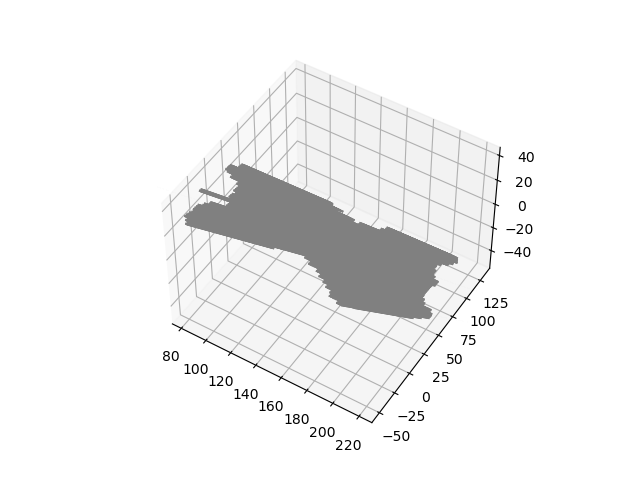

In [56]:
plt.figure()
ax = plt.axes(projection='3d')
for i in range(len(plotpoints)):
    ax.plot3D(plotpoints[i][0], plotpoints[i][1], plotpoints[i][2], 'gray')
    ax.plot3D(plotpoints[i][0], plotpoints[i][1], plotpoints[i][2], 'gray')

    

In [64]:
Grid = (Grid ==5)
print('Number of basis function')
Grid.sum()

Number of basis function


1046

In [134]:
xyz

[[82.13539990382303, 236.2553013287343, 77],
 [-40.14435368249885, 134.97634927714057, 87],
 [-52.14840856077498, 42.64012394920655, 47]]

In [259]:
#Grid = Grid == 5
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.voxels(Grid)

In [34]:
A = np.array(([[[1,2,3],[3,4,5]],[[7,8,9],[9,10,11]]]))
A

array([[[ 1,  2,  3],
        [ 3,  4,  5]],

       [[ 7,  8,  9],
        [ 9, 10, 11]]])

In [202]:
file = 'cam'+str(n)+'/data/frame00000.png'
temp = Image.open(file)
temp = np.array(temp)
print(temp.shape)
temp = np.dsplit(temp,temp.shape[-1])
plt.imshow(temp[2])

(300, 320, 3)


In [180]:
tomoimage = network.avector.detach()
tomoimage = tomoimage.reshape(xyz[0][2],xyz[1][2],xyz[2][2])

In [220]:
import sys
import random
from PySide6 import QtCore, QtWidgets, QtGui

<IPython.core.display.Javascript object>


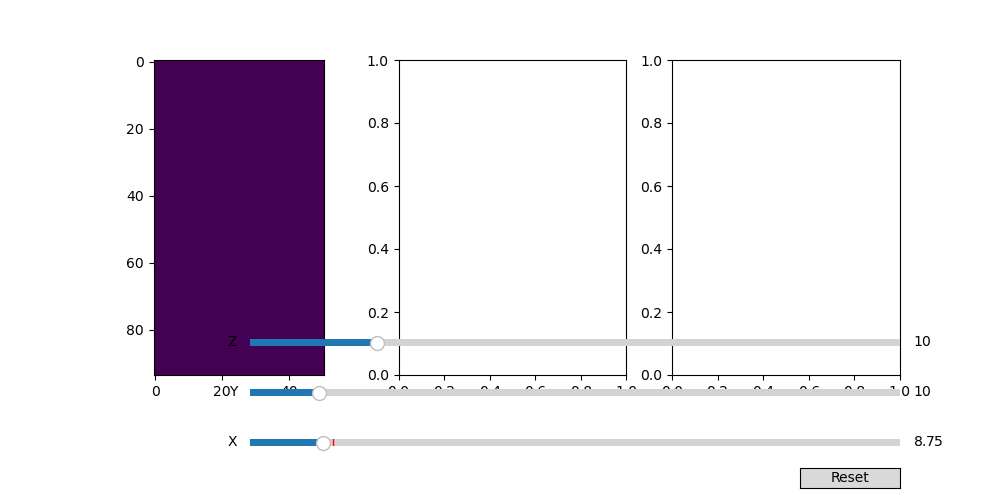

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3
x = 10
y = 10
z = 10

# Create the figure and the line that we will manipulate
# fig, ax = plt.subplots()
# line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
# ax.set_xlabel('Time [s]')

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.subplots_adjust(bottom=0.25)


# adjust the main plot to make room for the sliders
#fig.subplots_adjust(left=0.25, bottom=0.25)

im1 = axs[0].imshow(tomoimage[x,:,:])
#im2 = axs[1].imshow(rgbArray[:,y,:])
#im3 = axs[2].imshow(rgbArray[:,:,z])


# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.25, 0.1, 0.65, 0.03])
sliderx = Slider(
    ax=axamp,
    label="X",
    valmin=0,
    valmax=tomoimage.shape[0],
    valinit=x,
    orientation="horizontal",
)
axamp = fig.add_axes([0.25, 0.2, 0.65, 0.03])
slidery = Slider(
    ax=axamp,
    label="Y",
    valmin=0,
    valmax=tomoimage.shape[1],
    valinit=y,
    orientation="horizontal",
)
axamp = fig.add_axes([0.25, 0.3, 0.65, 0.03])
sliderz = Slider(
    ax=axamp,
    label="Z",
    
    valmin=0,
    valmax=tomoimage.shape[2],
    valinit=z,
    orientation="horizontal",
)


# The function to be called anytime a slider's value changes
def update(val):
    #line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    im1 = axs[0].imshow(tomoimage[int(sliderx.val),:,:])
    #im2 = axs[1].imshow(rgbArray[:,int(slidery.val),:])
    #im3 = axs[2].imshow(rgbArray[:,:,int(sliderz.val)])
    fig.canvas.draw_idle()


# register the update function with each slider
sliderx.on_changed(update)
slidery.on_changed(update)
sliderz.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    sliderx.reset()
    slidery.reset()
    sliderz.reset()
button.on_clicked(reset)

plt.show()

In [623]:
A = np.array((1,2,3,4,5,6,7,8))
A = A.reshape((2,2,2))

In [624]:
print(A)

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]


In [627]:
A[1][0][0]

5